# BMW Car Sales — Data Preparation & EDA
### INFO-523 Final Project | Min Set Khant (Solo)
#### This notebook performs: data audit, cleaning, feature engineering, EDA, temporal-split checks, and saves cleaned/processed datasets + key visuals for the dashboard.

 #### Setup, Imports, and Data Loading

In [1]:
# 1. SETUP AND IMPORTS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
%matplotlib inline

# Load the Data and Set Paths
DATA_PATH = Path("..") / "data" / "bmw_worldwide_sales.csv"
OUTPUT_DIR = Path("..") / "data" / "cleaned"
VISUALS_DIR = Path("..") / "visuals"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)

# Load Data
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"{DATA_PATH} not found. Ensure the file is in the correct path.")
    df = pd.DataFrame() # Create empty DF to prevent errors

if not df.empty:
    print("Raw shape:", df.shape)
    display(df.head(10))
    df.info()

Raw shape: (50000, 11)


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


#### Data Cleaning and Preparation

In [2]:
# Fix numeric types & simple conversions
num_cols = ["Year","Engine_Size_L","Mileage_KM","Price_USD","Sales_Volume"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Quick check
print(df[num_cols].isna().sum())

Year             0
Engine_Size_L    0
Mileage_KM       0
Price_USD        0
Sales_Volume     0
dtype: int64


In [3]:
# Derived features
CURRENT_YEAR = 2025
df["Car_Age"] = CURRENT_YEAR - df["Year"]
df["log_Price_USD"] = np.log1p(df["Price_USD"]) # Standardized name for target
df["Price_per_KM"] = df["Price_USD"] / df["Mileage_KM"].replace(0, np.nan)
df["Price_per_KM"] = df["Price_per_KM"].fillna(df["Price_per_KM"].median())

In [4]:
# Categorical Normalization

# Transmission normalization
df["Transmission"] = df["Transmission"].replace({
    "Auto": "Automatic",
    "Man": "Manual",
    "Automated Manual": "Automatic",
}).fillna("Unknown")

# Fuel check (ensure consistency, fill unknown)
df["Fuel_Type"] = df["Fuel_Type"].fillna("Other")

In [5]:
# Missing values & duplicates handling
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Impute Engine_Size_L per Model, fallback to global median
if "Engine_Size_L" in df.columns and "Model" in df.columns:
    df["Engine_Size_L"] = df.groupby("Model")["Engine_Size_L"].transform(lambda x: x.fillna(x.median()))
df["Engine_Size_L"] = df["Engine_Size_L"].fillna(df["Engine_Size_L"].median())

# Drop rows missing Price_USD (target)
before = df.shape[0]
df = df[~df["Price_USD"].isna()].copy()
after = df.shape[0]
print(f"Dropped {before-after} rows with missing Price_USD.")

Duplicates before: 0
Duplicates after: 0
Dropped 0 rows with missing Price_USD.


In [6]:
# Outlier check (as per proposal, no transformation needed for now)
def iqr_bounds(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25,75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

for c in ["Price_USD","Mileage_KM","Engine_Size_L","Sales_Volume"]:
    if c in df.columns:
        low, high = iqr_bounds(df[c].dropna(), k=1.5)
        pct_out = ((df[c] < low) | (df[c] > high)).mean() * 100
        print(f"{c}: IQR bounds [{low:.2f}, {high:.2f}], outliers ~ {pct_out:.3f}% ")

Price_USD: IQR bounds [-15355.50, 165418.50], outliers ~ 0.000% 
Mileage_KM: IQR bounds [-100500.38, 301308.62], outliers ~ 0.000% 
Engine_Size_L: IQR bounds [-0.15, 6.65], outliers ~ 0.000% 
Sales_Volume: IQR bounds [-4835.88, 14961.12], outliers ~ 0.000% 


#### Additional Feature Engineering

In [7]:
# Additional Feature Engineering (for EDA and modeling)

# Engine size bins
df["Engine_Bin"] = pd.cut(df["Engine_Size_L"], bins=[0,1.6,2.0,3.0,4.0,10],
                            labels=["<=1.6","1.7-2.0","2.1-3.0","3.1-4.0",">4.0"])
# Age bins
df["Age_Bin"] = pd.cut(df["Car_Age"], bins=[-1,1,3,6,10,100], labels=["0-1","2-3","4-6","7-10","10+"])
# Model popularity (Total Sales)
model_sales = df.groupby("Model")["Sales_Volume"].sum().rename("Total_Sales_Model").reset_index()
df = df.merge(model_sales, on="Model", how="left")

In [8]:
# Save cleaned CSV (for dashboard/visuals)
clean_path = OUTPUT_DIR / "bmw_cleaned.csv"
df.to_csv(clean_path, index=False)
print("Saved cleaned CSV to:", clean_path)

Saved cleaned CSV to: ../data/cleaned/bmw_cleaned.csv


## Exploratory Data Analysis (EDA) Visualizations


In [10]:
# Setup/Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
VISUALS_DIR = Path("..") / "visuals" 
os.makedirs(VISUALS_DIR, exist_ok=True) 

# Load the CLEANED data for visualizations
DATA_PATH = Path("..") / "data" / "cleaned" / "bmw_cleaned.csv"
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print("Error: Cleaned data not found.")

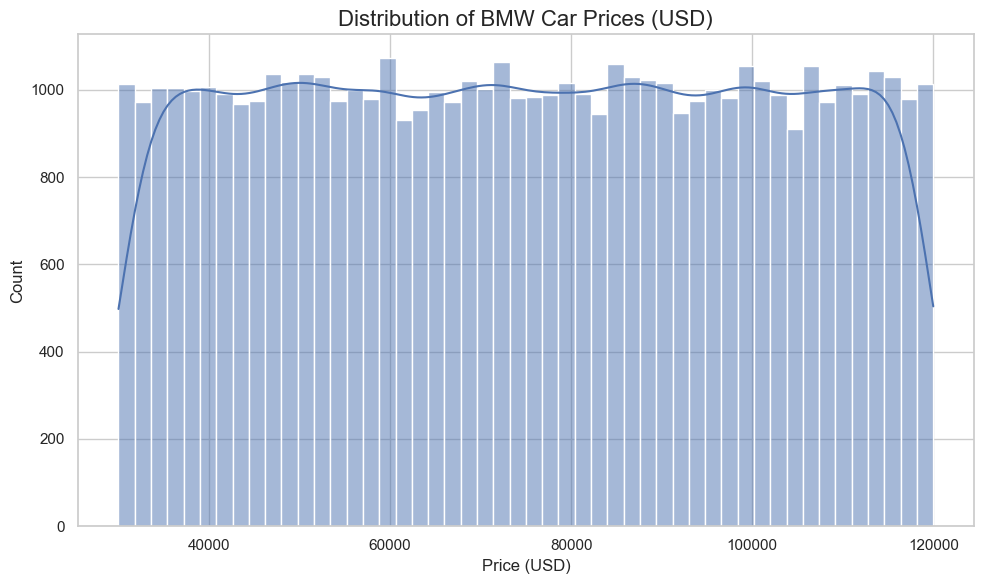

In [11]:
# Price Distribution (USD)
plt.figure(figsize=(10, 6))
sns.histplot(df["Price_USD"], kde=True, bins=50)
plt.title("Distribution of BMW Car Prices (USD)", fontsize=16)
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(VISUALS_DIR / "price_distribution.png")
plt.show()

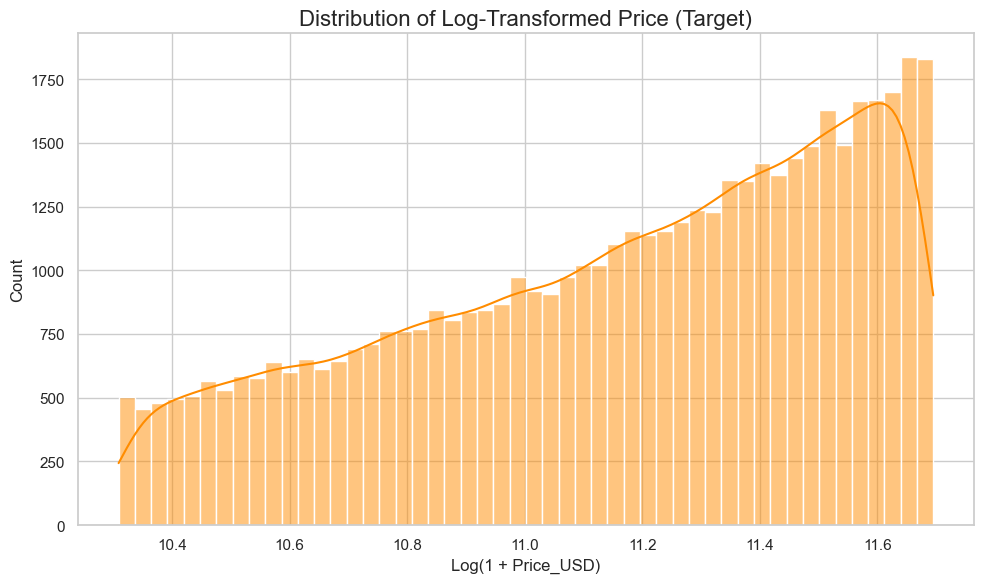

In [12]:
# Log-Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["log_Price_USD"], kde=True, bins=50, color='darkorange')
plt.title("Distribution of Log-Transformed Price (Target)", fontsize=16)
plt.xlabel("Log(1 + Price_USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(VISUALS_DIR / "log_price_distribution.png")
plt.show()

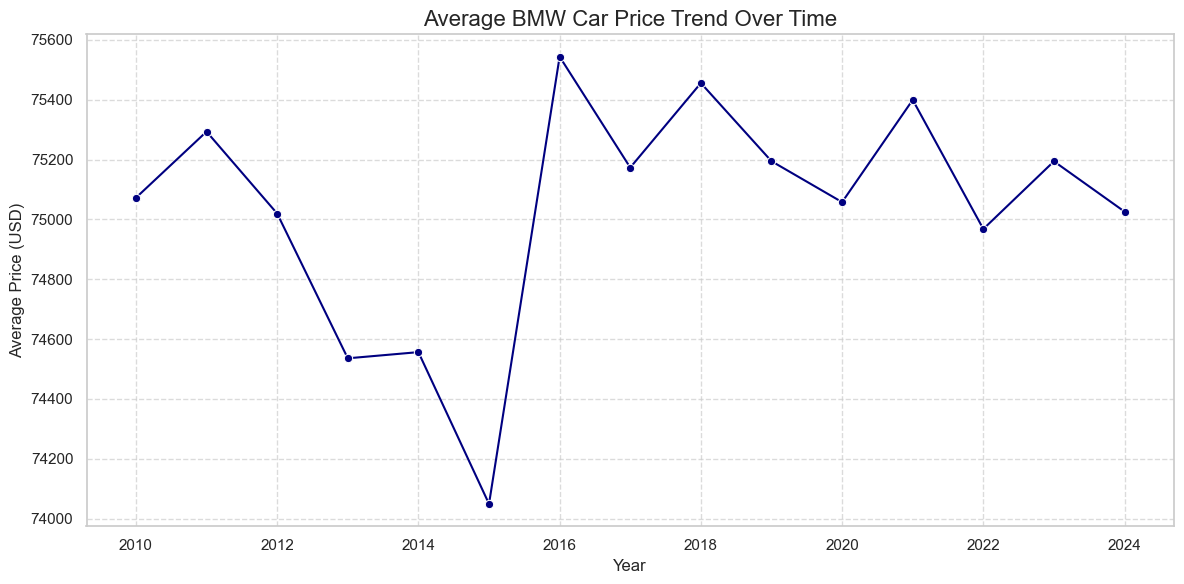

In [13]:
# Average Price Trend by Year
plt.figure(figsize=(12, 6))
avg_price_year = df.groupby("Year")["Price_USD"].mean().reset_index()
sns.lineplot(x="Year", y="Price_USD", data=avg_price_year, marker='o', color='navy')
plt.title("Average BMW Car Price Trend Over Time", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Price (USD)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(VISUALS_DIR / "avg_price_by_year.png")
plt.show()

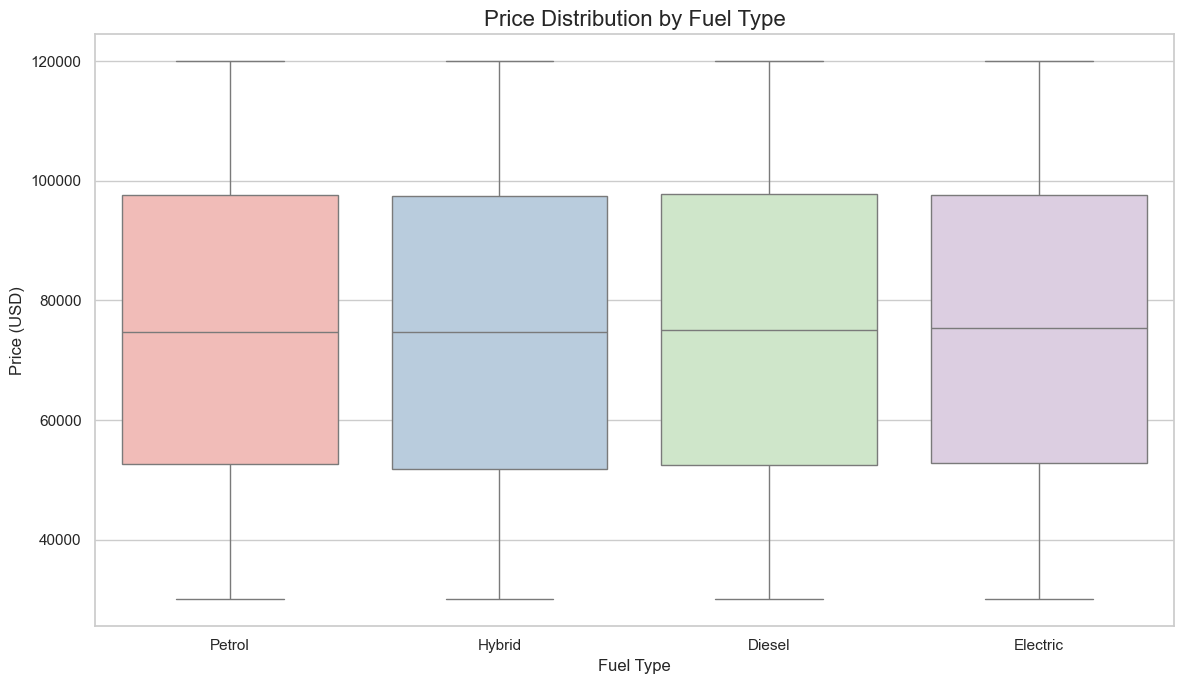

In [14]:
# Price by Fuel Type
plt.figure(figsize=(12, 7))
sns.boxplot(x="Fuel_Type", y="Price_USD", data=df, palette="Pastel1", showfliers=False)
plt.title("Price Distribution by Fuel Type", fontsize=16)
plt.xlabel("Fuel Type")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.savefig(VISUALS_DIR / "price_by_fueltype_box.png")
plt.show()

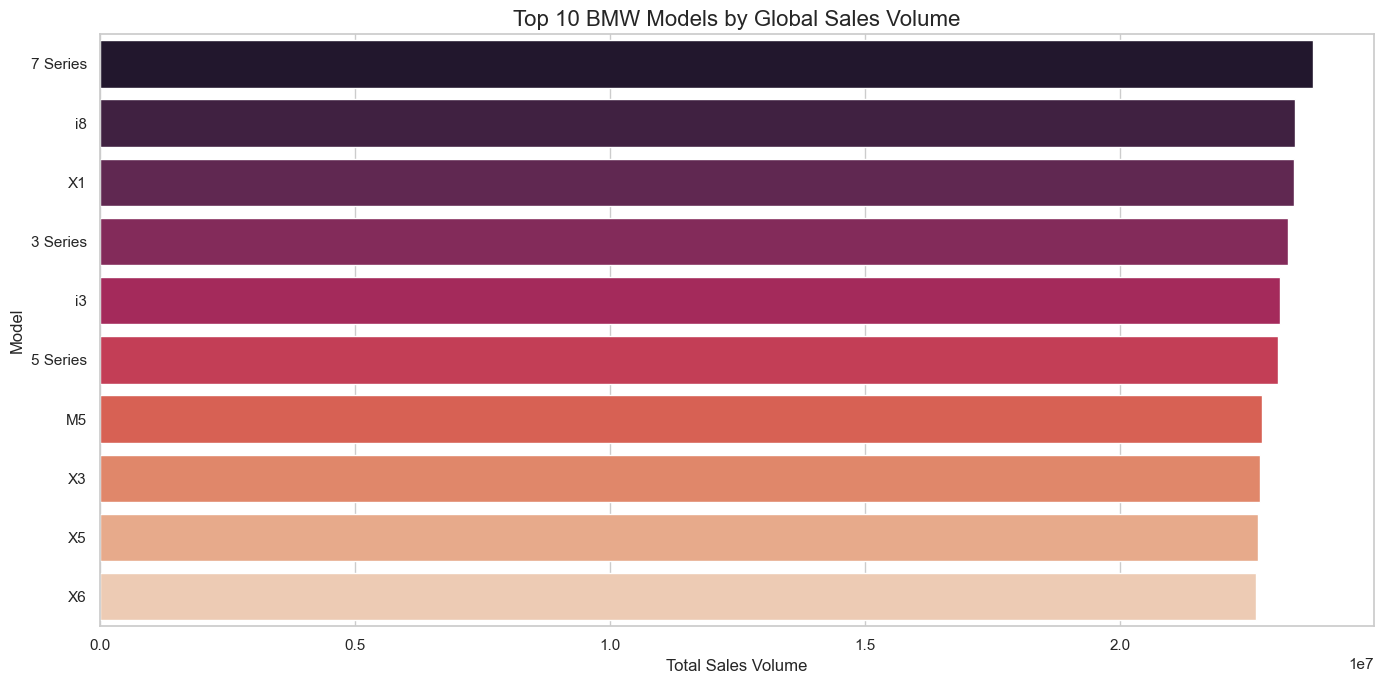

In [15]:
# Top 10 Models Globally (Sales Volume)
plt.figure(figsize=(14, 7))
# Calculate total sales volume per model
top_models = df.groupby('Model')['Sales_Volume'].sum().nlargest(10).sort_values(ascending=False).reset_index()

sns.barplot(x='Sales_Volume', y='Model', data=top_models, palette='rocket')
plt.title("Top 10 BMW Models by Global Sales Volume", fontsize=16)
plt.xlabel("Total Sales Volume")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(VISUALS_DIR / "top10_models_global.png")
plt.show()

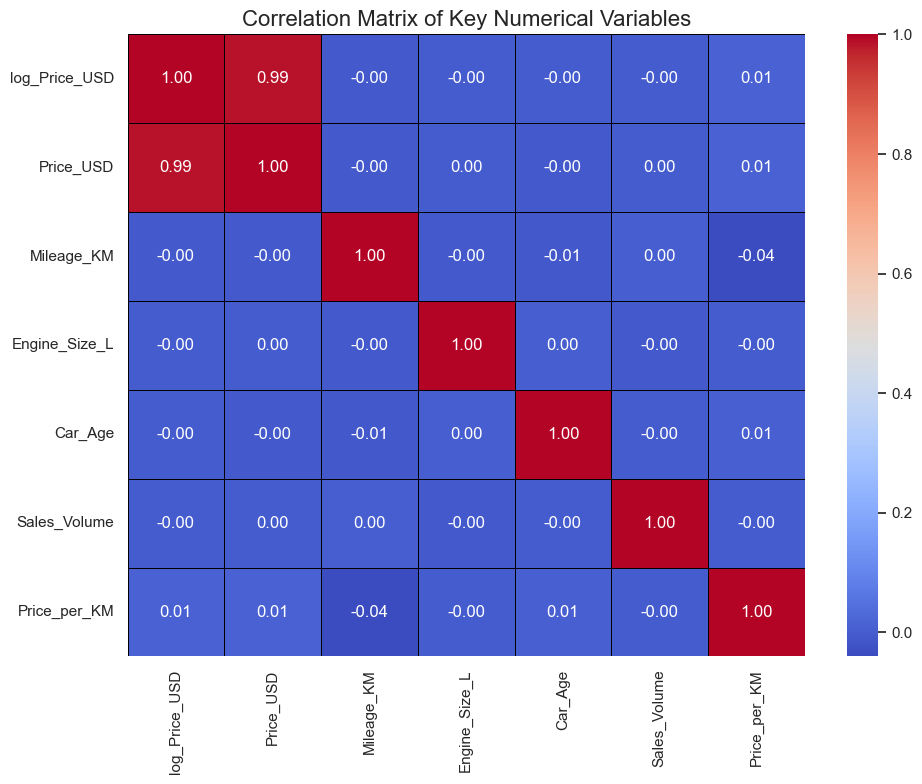

In [16]:
# Correlation Matrix (Heatmap)
# Selecting key numerical/quasi-numerical features
corr_cols = ['log_Price_USD', 'Price_USD', 'Mileage_KM', 'Engine_Size_L', 'Car_Age', 'Sales_Volume', 'Price_per_KM']
corr_df = df[corr_cols].dropna()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title("Correlation Matrix of Key Numerical Variables", fontsize=16)
plt.tight_layout()
plt.savefig(VISUALS_DIR / "correlation_matrix.png")
plt.show()

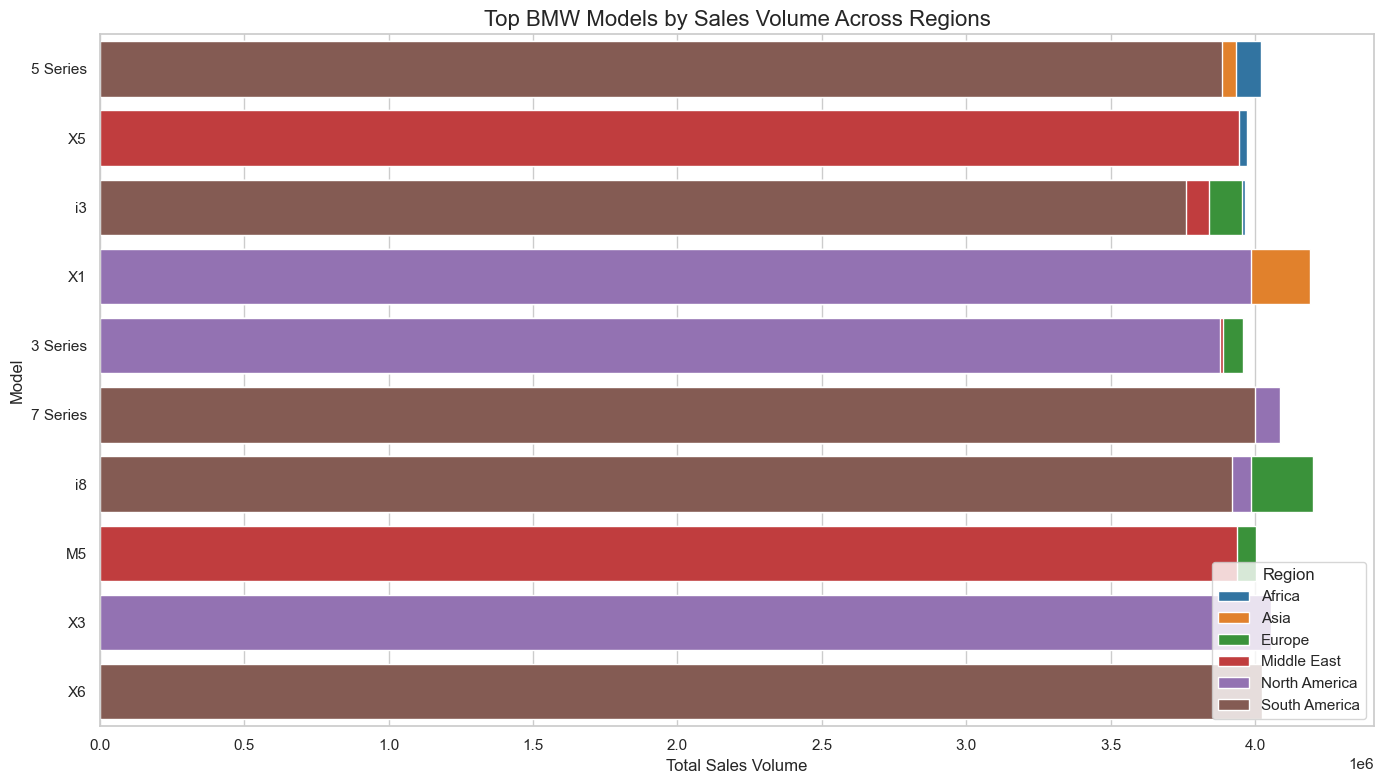

In [17]:
# Top Models by Region (Sales Volume)
# Calculate the top 5 models per region based on total sales volume
def get_top_models(group):
    return group.nlargest(5, 'Total_Sales_Model')

top_models_region = df.groupby(['Region', 'Model'])['Sales_Volume'].sum().reset_index()
top_models_region = top_models_region.rename(columns={'Sales_Volume': 'Total_Sales_Model'})
top_models_per_region = top_models_region.groupby('Region', group_keys=False).apply(get_top_models).reset_index(drop=True)

plt.figure(figsize=(14, 8))
sns.barplot(x='Total_Sales_Model', y='Model', hue='Region', data=top_models_per_region, dodge=False, palette='tab10')
plt.title("Top BMW Models by Sales Volume Across Regions", fontsize=16)
plt.xlabel("Total Sales Volume")
plt.ylabel("Model")
plt.legend(title='Region', loc='lower right')
plt.tight_layout()
plt.savefig(VISUALS_DIR / "top_model_per_region.png")
plt.show()

#### 4. Final Preparation for Modeling: Temporal Split Readiness
The final step prepares the dataset by converting categorical features into numerical ones using **One-Hot Encoding (OHE)** and dropping redundant columns. This **`bmw_modeling_ready.csv`** file is the essential input for the `02-modeling.ipynb` notebook.

In [18]:
# Prepare modeling-ready dataset
model_df = df.copy()

# Select columns for One-Hot Encoding (OHE)
cat_cols = ["Region","Model","Fuel_Type","Transmission","Color"]
model_df = pd.get_dummies(model_df, columns=[c for c in cat_cols if c in model_df.columns], drop_first=True)

# Drop original categorical columns
model_df = model_df.drop(columns=[c for c in cat_cols if c in model_df.columns], errors='ignore')

# Drop columns that are redundant/not used in modeling, but were useful for EDA/initial features
# Note: Price_USD is kept here so it can be extracted in 02-modeling for the final MAE calculation
cols_to_drop = ["Sales_Classification", "Engine_Bin", "Age_Bin", "index"] 
model_df = model_df.drop(columns=[c for c in cols_to_drop if c in model_df.columns], errors='ignore')

# Save modeling-ready CSV 
processed_path = OUTPUT_DIR / "bmw_modeling_ready.csv" 
model_df.to_csv(processed_path, index=False)
print("Saved modeling-ready CSV:", processed_path)
print("Final Modeling Shape:", model_df.shape)

Saved modeling-ready CSV: ../data/cleaned/bmw_modeling_ready.csv
Final Modeling Shape: (50000, 33)
